### 1. Setup (Persiapan Awal)

In [1]:
# Diperlukan Python versi 3.5 atau lebih tinggi
import sys
assert sys.version_info >= (3, 5)

# Diperlukan Scikit-Learn versi 0.20 atau lebih tinggi
import sklearn
assert sklearn.__version__ >= "0.20"

# Impor umum
import numpy as np
import os

# Untuk membuat output notebook ini stabil di setiap kali dijalankan
np.random.seed(42)

# Untuk membuat plot yang cantik
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Direktori untuk menyimpan gambar
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Fungsi untuk menyimpan gambar
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Menyimpan gambar", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 2. Klasifikasi SVM Linear
SVM bekerja dengan cara mencari garis (atau bidang di dimensi yang lebih tinggi) yang paling baik memisahkan dua kelas. Ini disebut Large Margin Classification, karena SVM mencoba memaksimalkan lebar "jalan" (margin) di antara kelas.



(np.float64(0.0), np.float64(5.5), np.float64(0.0), np.float64(2.0))

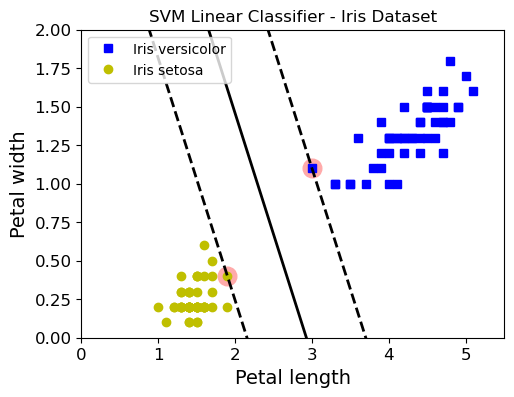

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

# Muat dataset Iris
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # ambil fitur petal length dan petal width
y = iris["target"]

# Kita hanya akan memisahkan dua kelas: Setosa dan Versicolor
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# Buat model SVM Classifier
# C=float("inf") berarti kita tidak mau ada kesalahan klasifikasi sama sekali (Hard Margin)
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

# Fungsi untuk plot decision boundary
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # Pada decision boundary, w0*x0 + w1*x1 + b = 0
    # Sehingga x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

# Plot hasil SVM pada Iris dataset
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title("SVM Linear Classifier - Iris Dataset")
plt.axis([0, 5.5, 0, 2])

#### Pentingnya Skala Fitur (Feature Scaling)
SVM sangat sensitif terhadap skala fitur. Jika satu fitur memiliki rentang nilai yang jauh lebih besar dari yang lain (misal: 1-1000 vs 0-1), SVM akan lebih condong ke fitur dengan rentang yang lebih kecil. Oleh karena itu, penting untuk melakukan penskalaan.

Menyimpan gambar svm_iris_and_scaling


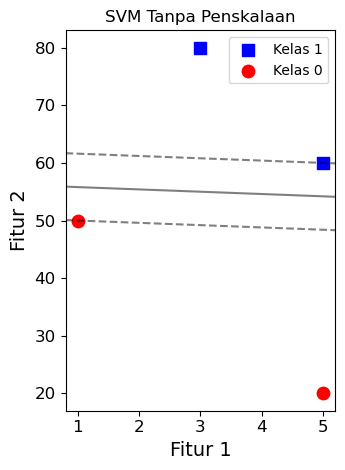

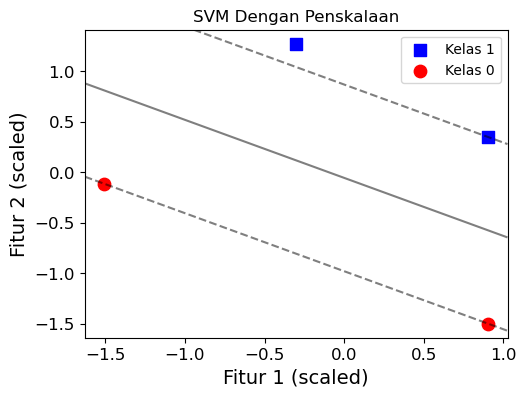

In [3]:
from sklearn.preprocessing import StandardScaler

# Data contoh dengan skala yang sangat berbeda
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

# --- Plot Tanpa Penskalaan ---
plt.subplot(122)
svm_clf1 = SVC(kernel="linear", C=100, random_state=42)
svm_clf1.fit(Xs, ys)

plt.scatter(Xs[:, 0][ys==1], Xs[:, 1][ys==1], s=80, c='blue', marker='s', label="Kelas 1")
plt.scatter(Xs[:, 0][ys==0], Xs[:, 1][ys==0], s=80, c='red', marker='o', label="Kelas 0")

# Plot decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Buat grid
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = svm_clf1.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary dan margin
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.title("SVM Tanpa Penskalaan")
plt.legend()

plt.tight_layout()
save_fig("svm_iris_and_scaling")
plt.show()

# --- Plot Dengan Penskalaan ---
plt.figure(figsize=(12, 4))

plt.subplot(121)
# Buat objek scaler
scaler = StandardScaler()
# Lakukan penskalaan
X_scaled = scaler.fit_transform(Xs)
# Latih model dengan data yang sudah diskalakan
svm_clf2 = SVC(kernel="linear", C=100, random_state=42)
svm_clf2.fit(X_scaled, ys)

plt.scatter(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], s=80, c='blue', marker='s', label="Kelas 1")
plt.scatter(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], s=80, c='red', marker='o', label="Kelas 0")

# Plot decision boundary untuk data yang sudah diskalakan
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = svm_clf2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

plt.xlabel("Fitur 1 (scaled)")
plt.ylabel("Fitur 2 (scaled)")
plt.title("SVM Dengan Penskalaan")
plt.legend()

### 3. Klasifikasi Soft Margin
Hard Margin (tanpa toleransi kesalahan) memiliki dua masalah utama:

- Hanya berfungsi jika data dapat dipisahkan secara linear.
- Sangat sensitif terhadap outlier (data pencilan).

Solusinya adalah Soft Margin Classification. Kita mengizinkan beberapa data untuk "melanggar batas" atau bahkan salah klasifikasi. Tingkat "kelonggaran" ini diatur oleh hyperparameter C.

- C kecil: Margin lebih lebar, tapi lebih banyak pelanggaran. Mencegah overfitting.
- C besar: Margin lebih sempit, tapi lebih sedikit pelanggaran. Bisa menyebabkan overfitting.

Prediksi untuk [5.5, 1.7]: 1.0 (Virginica)
Menyimpan gambar svm_scaling_and_virginica


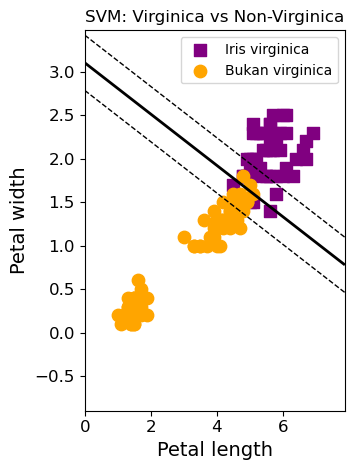

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # 1 jika Iris virginica, 0 jika bukan

# Membuat pipeline: penskalaan diikuti oleh model SVM
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

# Prediksi data baru
prediction = svm_clf.predict([[5.5, 1.7]])
print(f"Prediksi untuk [5.5, 1.7]: {prediction[0]} ({'Virginica' if prediction[0] else 'Bukan Virginica'})")

# Plot hasil klasifikasi Virginica vs Non-Virginica
plt.subplot(122)
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], s=80, c='purple', marker='s', label="Iris virginica")
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], s=80, c='orange', marker='o', label="Bukan virginica")

# Buat decision boundary
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='-', linewidths=2)
plt.contour(xx, yy, Z, levels=[-1, 1], colors='k', linestyles='--', linewidths=1)

plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("SVM: Virginica vs Non-Virginica")
plt.legend()

plt.tight_layout()
save_fig("svm_scaling_and_virginica")
plt.show()

### 4. Klasifikasi SVM Non-Linear
Bagaimana jika data tidak bisa dipisahkan dengan garis lurus? Kita bisa menggunakan trik cerdas: menambahkan lebih banyak fitur. Misalnya, fitur yang merupakan kuadrat dari fitur asli. Ini bisa membuat data yang tadinya tidak terpisahkan menjadi terpisahkan di dimensi yang lebih tinggi.

/home/ardi/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


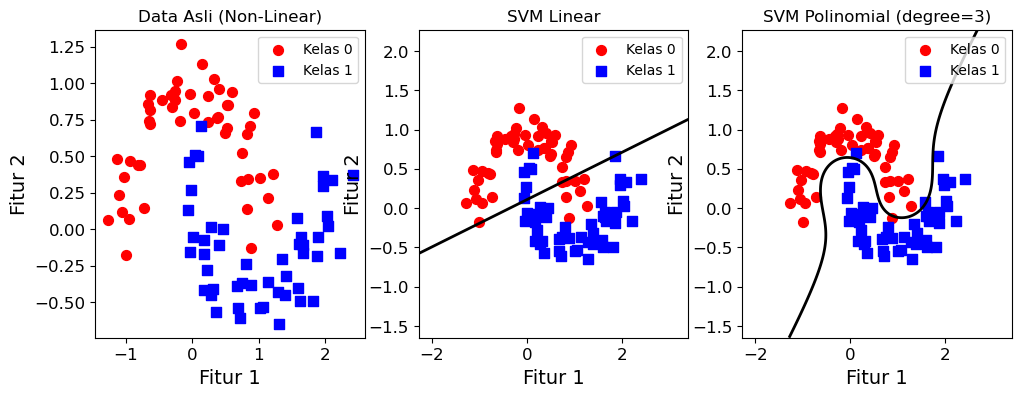

In [5]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

# Buat dataset "bulan sabit" yang tidak bisa dipisah secara linear
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

# Plot data asli
plt.figure(figsize=(16, 4))

plt.subplot(141)
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='red', marker='o', s=50, label='Kelas 0')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='blue', marker='s', s=50, label='Kelas 1')
plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.title("Data Asli (Non-Linear)")
plt.legend()

# 1. SVM Linear (tidak akan bagus untuk data ini)
linear_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])
linear_svm_clf.fit(X, y)

plt.subplot(142)
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='red', marker='o', s=50, label='Kelas 0')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='blue', marker='s', s=50, label='Kelas 1')

# Plot decision boundary
h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = linear_svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='-', linewidths=2)
plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.title("SVM Linear")
plt.legend()

# 2. Buat pipeline untuk SVM dengan fitur polinomial
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

plt.subplot(143)
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='red', marker='o', s=50, label='Kelas 0')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='blue', marker='s', s=50, label='Kelas 1')

Z = polynomial_svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='-', linewidths=2)
plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.title("SVM Polinomial (degree=3)")
plt.legend()

#### Trik Kernel (The Kernel Trick)
Menambahkan fitur polinomial bisa sangat lambat jika derajatnya tinggi. Trik kernel memungkinkan kita mendapatkan hasil yang sama tanpa benar-benar membuat fitur tambahan. Ini sangat efisien.

##### - Kernel Polinomial:

Menyimpan gambar svm_polynomial_comparison


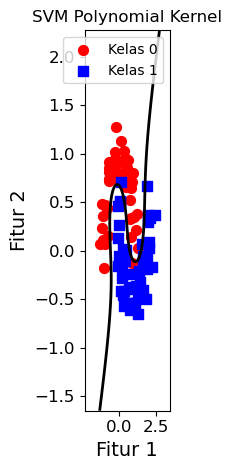

In [6]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5, random_state=42))
    ])
poly_kernel_svm_clf.fit(X, y)

plt.subplot(144)
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='red', marker='o', s=50, label='Kelas 0')
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='blue', marker='s', s=50, label='Kelas 1')

Z = poly_kernel_svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='-', linewidths=2)
plt.xlabel("Fitur 1")
plt.ylabel("Fitur 2")
plt.title("SVM Polynomial Kernel")
plt.legend()

plt.tight_layout()
save_fig("svm_polynomial_comparison")
plt.show()

##### - Kernel Gaussian RBF (Radial Basis Function): 
Kernel ini sangat populer dan kuat. Ia bekerja dengan mengukur "kemiripan" setiap data dengan beberapa titik landmark.

Menyimpan gambar svm_rbf_comparison


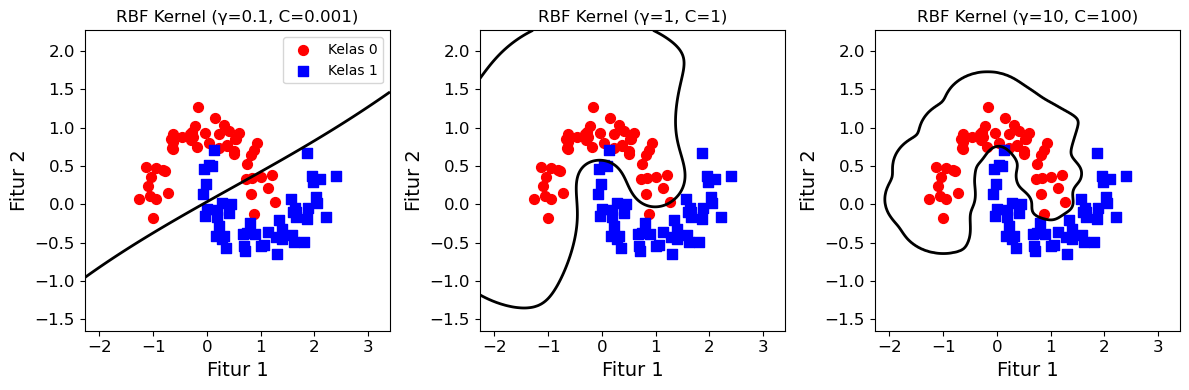

In [7]:
plt.figure(figsize=(12, 4))

# RBF Kernel dengan parameter gamma yang berbeda
gamma_values = [0.1, 1, 10]
C_values = [0.001, 1, 100]

for i, (gamma, C) in enumerate(zip(gamma_values, C_values)):
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C, random_state=42))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    
    plt.subplot(1, 3, i+1)
    plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='red', marker='o', s=50, label='Kelas 0')
    plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='blue', marker='s', s=50, label='Kelas 1')

    Z = rbf_kernel_svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='-', linewidths=2)
    plt.xlabel("Fitur 1")
    plt.ylabel("Fitur 2")
    plt.title(f"RBF Kernel (γ={gamma}, C={C})")
    if i == 0:
        plt.legend()

plt.tight_layout()
save_fig("svm_rbf_comparison")
plt.show()

### 5. SVM Regresi
SVM juga bisa digunakan untuk regresi (memprediksi nilai kontinu). Tujuannya dibalik: jika pada klasifikasi kita ingin "jalan" seluas mungkin dan kosong dari data, pada regresi kita ingin sebanyak mungkin data berada di dalam "jalan". Lebar jalan ini dikontrol oleh epsilon (ϵ).

Menyimpan gambar svm_linear_regression


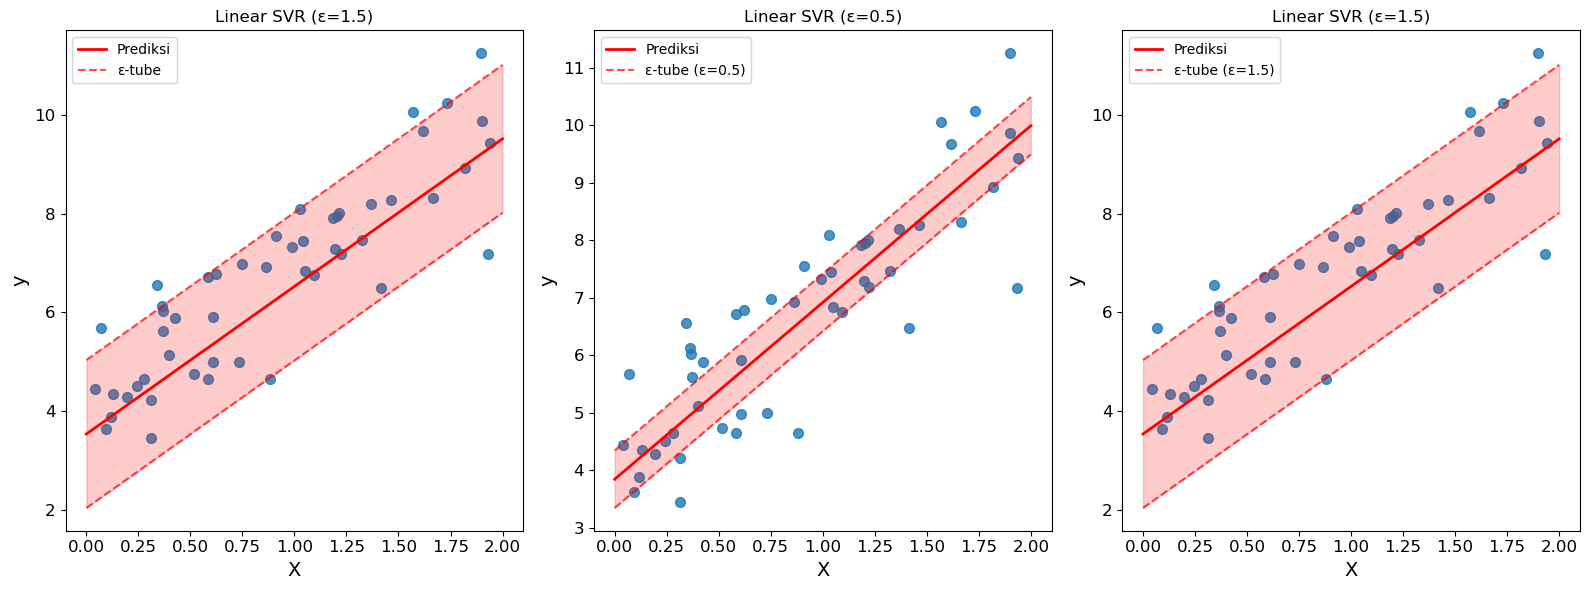

In [8]:
from sklearn.svm import LinearSVR, SVR

plt.figure(figsize=(16, 6))

# 1. Linear SVR
np.random.seed(42)
m = 50
X_reg = 2 * np.random.rand(m, 1)
y_reg = (4 + 3 * X_reg + np.random.randn(m, 1)).ravel()

# Buat model regresi SVM linear
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X_reg, y_reg)

plt.subplot(131)
plt.scatter(X_reg, y_reg, alpha=0.8, s=50)

# Plot garis regresi dan margin
X_reg_plot = np.linspace(0, 2, 100).reshape(-1, 1)
y_pred = svm_reg.predict(X_reg_plot)

plt.plot(X_reg_plot, y_pred, 'r-', linewidth=2, label='Prediksi')
plt.plot(X_reg_plot, y_pred + 1.5, 'r--', alpha=0.7, label='ε-tube')
plt.plot(X_reg_plot, y_pred - 1.5, 'r--', alpha=0.7)
plt.fill_between(X_reg_plot.ravel(), y_pred - 1.5, y_pred + 1.5, alpha=0.2, color='red')

plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear SVR (ε=1.5)")
plt.legend()

# 2. SVR dengan berbagai epsilon
epsilons = [0.5, 1.5]
for i, epsilon in enumerate(epsilons):
    svm_reg_eps = LinearSVR(epsilon=epsilon, random_state=42)
    svm_reg_eps.fit(X_reg, y_reg)
    
    plt.subplot(1, 3, i+2)
    plt.scatter(X_reg, y_reg, alpha=0.8, s=50)
    
    y_pred = svm_reg_eps.predict(X_reg_plot)
    plt.plot(X_reg_plot, y_pred, 'r-', linewidth=2, label='Prediksi')
    plt.plot(X_reg_plot, y_pred + epsilon, 'r--', alpha=0.7, label=f'ε-tube (ε={epsilon})')
    plt.plot(X_reg_plot, y_pred - epsilon, 'r--', alpha=0.7)
    plt.fill_between(X_reg_plot.ravel(), y_pred - epsilon, y_pred + epsilon, alpha=0.2, color='red')
    
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(f"Linear SVR (ε={epsilon})")
    plt.legend()

plt.tight_layout()
save_fig("svm_linear_regression")
plt.show()

#### Kode Regresi Non-Linear:

Menyimpan gambar svm_polynomial_regression


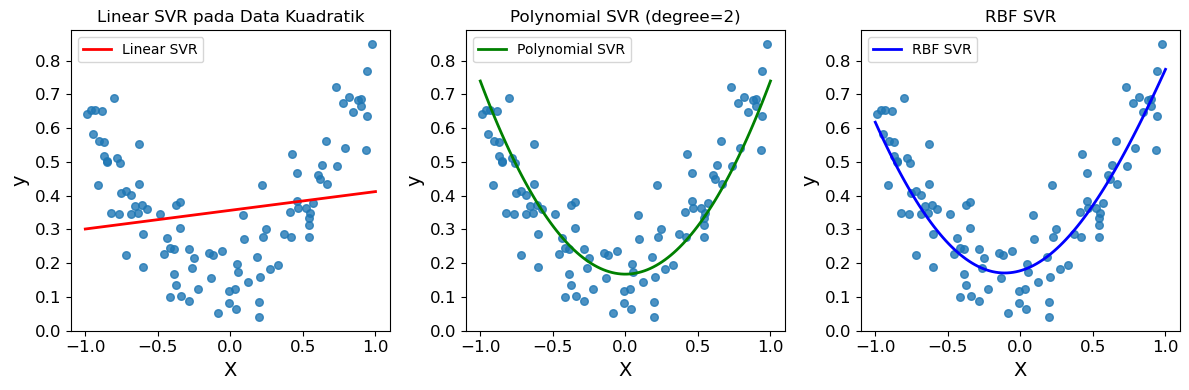

In [9]:
# Buat data non-linear (kuadratik)
np.random.seed(42)
m = 100
X_poly = 2 * np.random.rand(m, 1) - 1
y_poly = (0.2 + 0.1 * X_poly + 0.5 * X_poly**2 + np.random.randn(m, 1)/10).ravel()

plt.figure(figsize=(12, 4))

# Linear SVR (tidak akan bagus untuk data kuadratik)
linear_svr = LinearSVR(epsilon=0.1, random_state=42)
linear_svr.fit(X_poly, y_poly)

plt.subplot(131)
plt.scatter(X_poly, y_poly, alpha=0.8, s=30)

X_poly_plot = np.linspace(-1, 1, 100).reshape(-1, 1)
y_pred_linear = linear_svr.predict(X_poly_plot)

plt.plot(X_poly_plot, y_pred_linear, 'r-', linewidth=2, label='Linear SVR')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear SVR pada Data Kuadratik")
plt.legend()

# SVR dengan kernel polinomial
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma='scale')
svm_poly_reg.fit(X_poly, y_poly)

plt.subplot(132)
plt.scatter(X_poly, y_poly, alpha=0.8, s=30)

y_pred_poly = svm_poly_reg.predict(X_poly_plot)
plt.plot(X_poly_plot, y_pred_poly, 'g-', linewidth=2, label='Polynomial SVR')

plt.xlabel("X")
plt.ylabel("y")
plt.title("Polynomial SVR (degree=2)")
plt.legend()

# SVR dengan RBF kernel
svm_rbf_reg = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svm_rbf_reg.fit(X_poly, y_poly)

plt.subplot(133)
plt.scatter(X_poly, y_poly, alpha=0.8, s=30)

y_pred_rbf = svm_rbf_reg.predict(X_poly_plot)
plt.plot(X_poly_plot, y_pred_rbf, 'b-', linewidth=2, label='RBF SVR')

plt.xlabel("X")
plt.ylabel("y")
plt.title("RBF SVR")
plt.legend()

plt.tight_layout()
save_fig("svm_polynomial_regression")
plt.show()

### 6. Perbandingan Performa Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

print("="*60)
print("RINGKASAN PERFORMA MODEL SVM")
print("="*60)

# Untuk klasifikasi (menggunakan data moons)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear SVM': Pipeline([("scaler", StandardScaler()), 
                           ("svm", LinearSVC(C=1, random_state=42))]),
    'Poly SVM': Pipeline([("scaler", StandardScaler()), 
                         ("svm", SVC(kernel="poly", degree=3, C=5, random_state=42))]),
    'RBF SVM': Pipeline([("scaler", StandardScaler()), 
                        ("svm", SVC(kernel="rbf", gamma=1, C=1, random_state=42))])
}

print("\nAKURASI KLASIFIKASI (Dataset Moons):")
print("-" * 40)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name:15}: {accuracy:.3f}")

# Untuk regresi
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_poly, y_poly, test_size=0.2, random_state=42)

reg_models = {
    'Linear SVR': LinearSVR(epsilon=0.1, random_state=42),
    'Poly SVR': SVR(kernel="poly", degree=2, C=100, epsilon=0.1),
    'RBF SVR': SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
}

print("\nMSE REGRESI (Dataset Kuadratik):")
print("-" * 40)
for name, model in reg_models.items():
    model.fit(X_reg_train, y_reg_train)
    y_pred = model.predict(X_reg_test)
    mse = mean_squared_error(y_reg_test, y_pred)
    print(f"{name:15}: {mse:.4f}")

print("\n" + "="*60)
print("TUTORIAL SVM SELESAI!")
print("Semua gambar telah disimpan di folder:", IMAGES_PATH)
print("="*60)

RINGKASAN PERFORMA MODEL SVM

AKURASI KLASIFIKASI (Dataset Moons):
----------------------------------------
Linear SVM     : 1.000
Poly SVM       : 1.000
RBF SVM        : 1.000

MSE REGRESI (Dataset Kuadratik):
----------------------------------------
Linear SVR     : 0.0306
Poly SVR       : 0.0084
RBF SVR        : 0.0069

TUTORIAL SVM SELESAI!
Semua gambar telah disimpan di folder: ./images/svm
